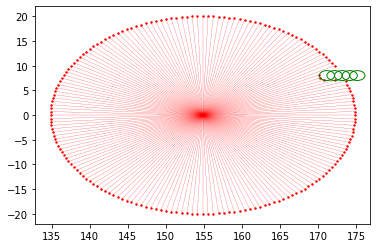

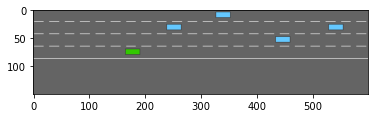

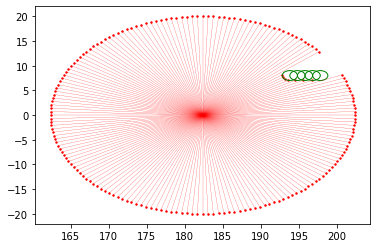

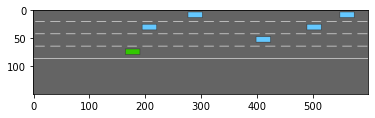

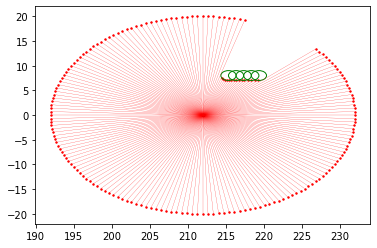

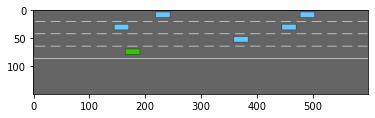

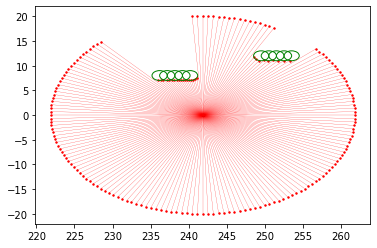

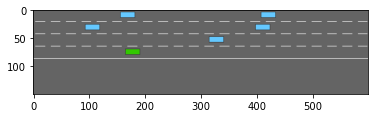

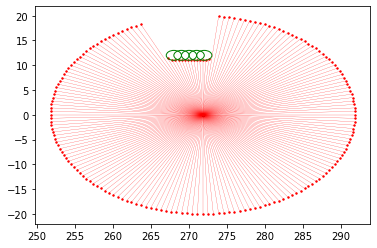

In [7]:
import gym
import highway_env
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

import math


local_var = {}

def check(local_var):
    agent = local_var['agent']
    neighbor = local_var['neighbor']
    agent_angle = local_var['agent_angle']
    endpoints = local_var['endpoints']
    lidar = local_var['lidar']
    smallest_endpoints = local_var['smallest_endpoints']
    
    #plot lidar
    for i in range(len(lidar)):
         plt.scatter(smallest_endpoints[i][0], smallest_endpoints[i][1], color = 'Red',s = 2)
    
    plt.scatter(agent[0],agent[1],color = 'Black',s=5)
    
 
    # plot car

    for i in range(len(neighbor)):
        for j in range(len(neighbor[0])):
            #plt.scatter(neighbor[i][j][0],neighbor[i][j][1] ,s=5, facecolors='none', edgecolors='b')
            circle1=plt.Circle((neighbor[i][j][0],neighbor[i][j][1]),1,color='green',fill=False)
            plt.gcf().gca().add_artist(circle1)
     
    plt.show()
    
def lidar_visualization(lidar,sensing_radius,agent_angle_copy,agent):
    smallest_endpoints = []
    
    for i in range(len(lidar)):
        x = lidar[i] * math.cos(math.radians(agent_angle_copy)) + agent[0] # get x coordinate
        y = lidar[i] * math.sin(math.radians(agent_angle_copy)) + agent[1] # get y coordinate
        smallest_endpoints.append((x,y))
        plt.plot([agent[0], x], [agent[1], y], color = 'Red', linewidth = 0.2)  # plot the line
        agent_angle_copy+=2
    
    plt.scatter(agent[0],agent[1],color = 'Blue',s=5)
    #plt.show()
    local_var['smallest_endpoints'] = smallest_endpoints

def find_endpoints(agent,agent_angle,sensing_radius):
    """<--------------------------- gives endpoint for the ray segment---------------------->"""
    count = 0
    x_point,y_point = [],[]
    while (count < 180):
        x_point.append(sensing_radius * math.cos(math.radians(agent_angle)) + agent[0])
        y_point.append(sensing_radius * math.sin(math.radians(agent_angle)) + agent[1])
        agent_angle+=2
        count+=1
    endpoints = list(zip(x_point,y_point))
    local_var['endpoints'] = endpoints
    return endpoints


def get_intersection(Q,r,P1,P2):
    """<---------------------Gives closest point of intersection to the circle---------------------->"""
    Q = np.array(Q)    # Centre of circle
    P1 = np.array(P1)    # Start of line segment
    P2 = np.array(P2)    # End
    V = P2 - P1    # Vector along line segment
   
    a = V.dot(V)
    b = 2 * V.dot(P1 - Q)
    c = P1.dot(P1) + Q.dot(Q) - 2 * P1.dot(Q) - r**2
    
    disc = b**2 - 4 * a * c
    if disc < 0:
        return False, None
    
    sqrt_disc = math.sqrt(disc)
    t1 = (-b + sqrt_disc) / (2 * a)
    t2 = (-b - sqrt_disc) / (2 * a)
    
    if not (0 <= t1 <= 1 or 0 <= t2 <= 1):
        return False, None
    
    t = min(t1,t2)
    return True,P1 + t * V


def display_lidar(position):
    """ <-------------------Agent-----------------------------> """
    position = position[position[:,0] == 1]  # considers only those vehicles which has presence 1
    position[:,2] = 12 - position[:,2]     # change y axis from 4th duadrant to 1st quadrant
    
    agent_X = position[0][1]    # Agent centre x
    agent_Y = position[0][2]    # Agent centre y
    
    agent = (agent_X,agent_Y)   # Agent position
    agent_inclination = math.degrees(math.acos(env.vehicle.heading))
    agent_angle = agent_inclination - 90    # angle wrt lane
    agent_angle_copy = agent_angle    # copy of angle needed ahead
    local_var['agent'] = agent
    local_var['agent_angle'] = agent_angle_copy
    """ <------------------------- Neighbor vehicles------------------> """
    disc_collection = []
    for i in range(1,len(position)):   # starts from 1 as 0 is our agent

        l = 5   # length of vehicle
        w = 2   # width of vehicle
        X = position[i][1]  # neighbor X
        Y = position[i][2]  # neighbor Y
        cos_h = position[i][5]
        sin_h = position[i][6]
        heading = np.arctan2(sin_h, cos_h)
        car_angle = math.degrees(math.acos(heading))
        yaw = car_angle - 90    # angle wrt lane

        num = int(np.ceil(l/w)-1)    # the total number of discs will be 2*num + 1 = 5
        s1 = np.array(range(-num,num+1)) 
        x_circles = X*np.ones(num*2+1) + s1*w/2*math.cos(math.radians(yaw))    # the x coordinates of the discs
        y_circles = Y*np.ones(num*2+1) + s1*w/2*math.sin(math.radians(yaw))    # the y-coordinates of the discs

        disc = list(zip(x_circles,y_circles))
        disc_collection.append(disc)

        
        
    """ <---------------------- check if the neighbor is within our sensing radius------------------> """ 
    neighbor = []
    sensing_radius = 20
    for n in disc_collection:
        disc_first = np.array(n[0])    # first disk
        disc_second = np.array(n[1])
        disc_third = np.array(n[2])
        disc_forth = np.array(n[3])
        disc_last = np.array(n[4])     # last disk

        # Checking if first or last disk is withing sensing radius (may be we dont need to check all disk)
        
        # compare  or squared distance (need to change this)
        if np.linalg.norm(agent - disc_first) < sensing_radius or np.linalg.norm(agent - disc_last) < sensing_radius or np.linalg.norm(agent - disc_second) < sensing_radius or np.linalg.norm(agent - disc_third) < sensing_radius or np.linalg.norm(agent - disc_forth) < sensing_radius:
            neighbor.append(n)
            
    local_var['neighbor'] = neighbor
    
    """<------------------------- ray end points------------------------------->"""
    endpoints = find_endpoints(agent,agent_angle,sensing_radius)    # end point of the ray
    lidar = []
    for endpoint in endpoints:
        intersection = [sensing_radius]    # if no intersection then sensing radius will be the length of ray
        for disk_set in neighbor:
            for disk in disk_set:
                flag,point = get_intersection(disk,1,agent,endpoint)
                if flag!=False:
                    distance = np.linalg.norm(agent - point)    #Euclidean distance from agent centre
                    intersection.append(distance)
        lidar.append(min(intersection))    # The smallest intersection is stored
    
    """<--------------------------- visualize the lidar--------------------------->"""    
    lidar_visualization(lidar,sensing_radius,agent_angle_copy,agent)        
    local_var['lidar'] = lidar
    
    #check
    
    check(local_var)
    
    return lidar


if __name__ == '__main__':
    env = gym.make('highway-v0')
    
    config = {
    "observation": {
        "offscreen_rendering": True,
        "type": "Kinematics",
        "vehicles_count": 15,
        "initial_spacing":10,
        "features": ["presence", "x", "y", "vx", "vy","cos_h","sin_h"],
        "features_range": {
            "x": [0, 100],
            "y": [0, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "lanes_count": 2,
        "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
        "absolute": True,
        "order": "sorted",
        'render_agent': True,
        "normalize":False,
        "duration":100,
        'simulation_frequency': 20,

                    }
            }

    #env = gym.make('highway-v0')
    env.configure(config)                       # Update our configuration in the environment
    env.reset()

    flag = False
    for i in range(10):
        if flag == True:
            break
        observation = env.reset()
        done = False
        episode = 0
        
        while not done:
            episode+=1
            flag = True
            lidar = display_lidar(observation)
            if episode == 5:
                break
            observation_, reward, done, info = env.step(env.action_space.sample())
            env.render()
            plt.imshow(env.render(mode='rgb_array'))
            display.display(plt.gcf())    
            plt.clf()
            observation = observation_

    #env.close()

 









In [8]:
env.close()